In [0]:
import numpy as np
import pandas as pd
from sklearn import *

In [2]:
#Loading the data in pandas DataFrame
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
structures = pd.read_csv('./structures.csv')
#mc = pd.read_csv('../input/mulliken_charges.csv')
#scc = pd.read_csv('../input/scalar_coupling_contributions.csv')

print(train.shape, test.shape)
print(train.head())
print(test.head())

(4540620, 6) (2505542, 5)
   id     molecule_name  ...  type  scalar_coupling_constant
0   0  dsgdb9nsd_000001  ...  1JHC                   84.8076
1   1  dsgdb9nsd_000001  ...  2JHH                  -11.2570
2   2  dsgdb9nsd_000001  ...  2JHH                  -11.2548
3   3  dsgdb9nsd_000001  ...  2JHH                  -11.2543
4   4  dsgdb9nsd_000001  ...  1JHC                   84.8074

[5 rows x 6 columns]
        id     molecule_name  atom_index_0  atom_index_1  type
0  4658147  dsgdb9nsd_000004             2             0  2JHC
1  4658148  dsgdb9nsd_000004             2             1  1JHC
2  4658149  dsgdb9nsd_000004             2             3  3JHH
3  4658150  dsgdb9nsd_000004             3             0  1JHC
4  4658151  dsgdb9nsd_000004             3             1  2JHC


In [0]:
#To convert the datatypes of the columns in the dataframe to reduce memeory usage

def type_conversion(pds_obj):
    
    optimized_obj = pds_obj.copy()
    
    #selecting all columns with integer datatype
    int_col = pds_obj.select_dtypes(include=['int64'])
    if len(int_col.columns)==0:
        pass
    else:
        new_int = int_col.apply(pd.to_numeric,downcast='unsigned')
        optimized_obj[int_col.columns] = new_int
    
    #selecting all columns with float datatype
    float_col = pds_obj.select_dtypes('float')
    if len(float_col.columns)==0:
        pass
    else:
        new_float = float_col.apply(pd.to_numeric,downcast='float')
        optimized_obj[float_col.columns] = new_float
    #selecting all columns with object datatype
    objects = pds_obj.select_dtypes('object').copy()
    if len(objects.columns)==0:
        pass
    else:
        obj =objects.astype('category')
        optimized_obj[objects.columns]=obj
    
    

    
    
    
    return optimized_obj

In [0]:
#function to print the memory usage by the dataframe
def mem_info(df):
    print(df.info(memory_usage='deep'))

In [5]:
mem_info(train)
mem_info(test)
mem_info(structures)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540620 entries, 0 to 4540619
Data columns (total 6 columns):
id                          int64
molecule_name               object
atom_index_0                int64
atom_index_1                int64
type                        object
scalar_coupling_constant    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 718.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505542 entries, 0 to 2505541
Data columns (total 5 columns):
id               int64
molecule_name    object
atom_index_0     int64
atom_index_1     int64
type             object
dtypes: int64(3), object(2)
memory usage: 377.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358657 entries, 0 to 2358656
Data columns (total 6 columns):
molecule_name    object
atom_index       int64
atom             object
x                float64
y                float64
z                float64
dtypes: float64(3), int64(1), object(2)
memory usage: 384.6 MB
None


In [0]:
# reducing the memory usage
train=type_conversion(train)
test = type_conversion(test)
structures=type_conversion(structures)


In [7]:
mem_info(train)
mem_info(test)
mem_info(structures)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540620 entries, 0 to 4540619
Data columns (total 6 columns):
id                          uint32
molecule_name               category
atom_index_0                uint8
atom_index_1                uint8
type                        category
scalar_coupling_constant    float32
dtypes: category(2), float32(1), uint32(1), uint8(2)
memory usage: 73.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505542 entries, 0 to 2505541
Data columns (total 5 columns):
id               uint32
molecule_name    category
atom_index_0     uint8
atom_index_1     uint8
type             category
dtypes: category(2), uint32(1), uint8(2)
memory usage: 30.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358657 entries, 0 to 2358656
Data columns (total 6 columns):
molecule_name    category
atom_index       uint8
atom             category
x                float32
y                float32
z                float32
dtypes: category(2), float32(3)

In [8]:
#Selecting each atom from molecule type and encoding it to numeric datatype#Selecting each atom from molecule type and encoding it to numeric datatype
lbl = preprocessing.LabelEncoder()
for i in range(4):
    train['type'+str(i)] = lbl.fit_transform(train['type'].map(lambda x: str(x)[i])).astype('uint8')
    test['type'+str(i)] = lbl.transform(test['type'].map(lambda x: str(x)[i])).astype('uint8')



print(len(train))
print("\n\n",train.head())

4540620


    id     molecule_name  atom_index_0  atom_index_1  ... type0  type1  type2  type3
0   0  dsgdb9nsd_000001             1             0  ...     0      0      0      0
1   1  dsgdb9nsd_000001             1             2  ...     1      0      0      1
2   2  dsgdb9nsd_000001             1             3  ...     1      0      0      1
3   3  dsgdb9nsd_000001             1             4  ...     1      0      0      1
4   4  dsgdb9nsd_000001             2             0  ...     0      0      0      0

[5 rows x 10 columns]


Now we need to merge all the x y z values in structures DataFrame to the train and test set with respect to their molecule name and atom index to later use these features to calculate more complex features.

In [0]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [10]:
print(train.shape)
print(test.shape)

(4540620, 18)
(2505542, 17)


Droping the unnecessary columns.

In [11]:
train.drop(columns=['id', 'molecule_name'], inplace=True)
test.drop(columns=['id','molecule_name'], inplace=True)
print(train.shape, test.shape)

(4540620, 16) (2505542, 15)


Now we calculate the euclidean distance between the x0,y0,z0 and x1,y1,z1 for each molecule and store it in the train and test dataframe.

In [0]:

train_p0 = train[['x_0', 'y_0', 'z_0']].values
train_p1 = train[['x_1', 'y_1', 'z_1']].values
test_p0 = test[['x_0', 'y_0', 'z_0']].values
test_p1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p0 - train_p1, axis=1)
test['dist'] = np.linalg.norm(test_p0 - test_p1, axis=1)



now lets calculate the distance between each co-ordinate with atom_idx 0,1

In [0]:


train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2



In [14]:
#Here take the mean, min and max distance for each molecule type and each atom in a type to get more specific distance features.

#mean
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('type0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('type0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('type1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('type1')['dist'].transform('mean')

train['dist_to_type_2_mean'] = train['dist'] / train.groupby('type2')['dist'].transform('mean')
test['dist_to_type_2_mean'] = test['dist'] / test.groupby('type2')['dist'].transform('mean')

train['dist_to_type_3_mean'] = train['dist'] / train.groupby('type3')['dist'].transform('mean')
test['dist_to_type_3_mean'] = test['dist'] / test.groupby('type3')['dist'].transform('mean')

#min
train['dist_to_type_min'] = train['dist'] / train.groupby('type')['dist'].transform('min')
test['dist_to_type_min'] = test['dist'] / test.groupby('type')['dist'].transform('min')

train['dist_to_type_0_min'] = train['dist'] / train.groupby('type0')['dist'].transform('min')
test['dist_to_type_0_min'] = test['dist'] / test.groupby('type0')['dist'].transform('min')

train['dist_to_type_1_min'] = train['dist'] / train.groupby('type1')['dist'].transform('min')
test['dist_to_type_1_min'] = test['dist'] / test.groupby('type1')['dist'].transform('min')

train['dist_to_type_2_min'] = train['dist'] / train.groupby('type2')['dist'].transform('min')
test['dist_to_type_2_min'] = test['dist'] / test.groupby('type2')['dist'].transform('min')

train['dist_to_type_3_min'] = train['dist'] / train.groupby('type3')['dist'].transform('min')
test['dist_to_type_3_min'] = test['dist'] / test.groupby('type3')['dist'].transform('min')

#max
train['dist_to_type_max'] = train['dist'] / train.groupby('type')['dist'].transform('max')
test['dist_to_type_max'] = test['dist'] / test.groupby('type')['dist'].transform('max')

train['dist_to_type_0_max'] = train['dist'] / train.groupby('type0')['dist'].transform('max')
test['dist_to_type_0_max'] = test['dist'] / test.groupby('type0')['dist'].transform('mean')

train['dist_to_type_1_max'] = train['dist'] / train.groupby('type1')['dist'].transform('max')
test['dist_to_type_1_max'] = test['dist'] / test.groupby('type1')['dist'].transform('max')

train['dist_to_type_2_max'] = train['dist'] / train.groupby('type2')['dist'].transform('max')
test['dist_to_type_2_max'] = test['dist'] / test.groupby('type2')['dist'].transform('max')

train['dist_to_type_3_max'] = train['dist'] / train.groupby('type3')['dist'].transform('max')
test['dist_to_type_3_max'] = test['dist'] / test.groupby('type3')['dist'].transform('max')

print(train.shape, test.shape)

(4540620, 35) (2505542, 34)


More complex features

In [15]:
 # This function calculates some aggregate features for each x,y,z co-ordinate with respect to it's atom_index


def features(df):
    for c in ['0', '1']:
        col = [c1 + c  for c1 in ['x_','y_','z_']]
        for agg in ['min', 'max', 'sum', 'mean', 'std']:
            df[c+agg] = eval('df[col].' + agg + '(axis=1)')
            df[c+'a'+agg] = eval('df[col].abs().' + agg + '(axis=1)')
    return df

train = features(train)
test = features(test)
print(train.shape, test.shape)

(4540620, 55) (2505542, 54)


In [16]:
train.head()

,atom_index_0,atom_index_1,type,scalar_coupling_constant,type0,type1,type2,type3,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean,dist_to_type_2_mean,dist_to_type_3_mean,dist_to_type_min,dist_to_type_0_min,dist_to_type_1_min,dist_to_type_2_min,dist_to_type_3_min,dist_to_type_max,dist_to_type_0_max,dist_to_type_1_max,dist_to_type_2_max,dist_to_type_3_max,0min,0amin,0max,0amax,0sum,0asum,0mean,0amean,0std,0astd,1min,1amin,1max,1amax,1sum,1asum,1mean,1amean,1std,1astd
0,1,0,1JHC,84.807602,0,0,0,0,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.000220,1.192104,0.000036,0.999087,1.002929,0.462068,0.462068,0.462641,1.029269,1.089387,1.089387,1.089387,1.029269,0.875003,0.875003,0.278250,0.278250,0.278250,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,-0.012698,0.008001,1.085804,1.085804,1.081107,1.106503,0.360369,0.368834,0.628330,0.620918
1,1,2,2JHH,-11.257000,1,0,0,1,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.019253,2.160260,0.000003,1.004500,0.852328,0.754541,0.754541,0.760862,1.178254,1.178254,1.778929,1.778929,1.178254,0.905440,0.707303,0.454373,0.454373,0.561151,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,0.000277,0.000277,1.463751,1.463751,2.475759,2.475759,0.825253,0.825253,0.749346,0.749346
2,1,3,2JHH,-11.254800,1,0,0,1,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,0.294812,2.112830,0.771973,1.004516,0.852341,0.754552,0.754552,0.760874,1.178272,1.178272,1.778957,1.778957,1.178272,0.905454,0.707314,0.454380,0.454380,0.561159,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,-0.876644,0.540815,1.447527,1.447527,0.030068,2.864985,0.010023,0.954995,1.256188,0.458406
3,1,4,2JHH,-11.254300,1,0,0,1,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,0.276638,2.085032,0.817978,1.004521,0.852345,0.754556,0.754556,0.760877,1.178278,1.178278,1.778966,1.778966,1.178278,0.905459,0.707318,0.454382,0.454382,0.561162,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,-0.523814,0.523814,1.437933,1.437933,1.820516,2.868144,0.606839,0.956048,1.014600,0.459078
4,2,0,1JHC,84.807404,0,0,0,0,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,1.049455,0.142844,0.000060,0.999086,1.002928,0.462068,0.462068,0.462640,1.029268,1.089385,1.089385,1.089385,1.029268,0.875002,0.875002,0.278250,0.278250,0.278250,0.000277,0.000277,1.463751,1.463751,2.475759,2.475759,0.825253,0.825253,0.749346,0.749346,-0.012698,0.008001,1.085804,1.085804,1.081107,1.106503,0.360369,0.368834,0.628330,0.620918


In [17]:
# Encoding the string type data to numeric datatype so that it can be used as traning data for the deep learning model

from sklearn.preprocessing import LabelEncoder


for f in ['atom_0', 'atom_1','type']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(train[f])
    test[f] = lbl.transform(test[f])
    
train.head()

,atom_index_0,atom_index_1,type,scalar_coupling_constant,type0,type1,type2,type3,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean,dist_to_type_2_mean,dist_to_type_3_mean,dist_to_type_min,dist_to_type_0_min,dist_to_type_1_min,dist_to_type_2_min,dist_to_type_3_min,dist_to_type_max,dist_to_type_0_max,dist_to_type_1_max,dist_to_type_2_max,dist_to_type_3_max,0min,0amin,0max,0amax,0sum,0asum,0mean,0amean,0std,0astd,1min,1amin,1max,1amax,1sum,1asum,1mean,1amean,1std,1astd
0,1,0,0,84.807602,0,0,0,0,0,0.002150,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,1.091953,0.000220,1.192104,0.000036,0.999087,1.002929,0.462068,0.462068,0.462641,1.029269,1.089387,1.089387,1.089387,1.029269,0.875003,0.875003,0.278250,0.278250,0.278250,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,-0.012698,0.008001,1.085804,1.085804,1.081107,1.106503,0.360369,0.368834,0.628330,0.620918
1,1,2,3,-11.257000,1,0,0,1,0,0.002150,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1.783120,1.019253,2.160260,0.000003,1.004500,0.852328,0.754541,0.754541,0.760862,1.178254,1.178254,1.778929,1.778929,1.178254,0.905440,0.707303,0.454373,0.454373,0.561151,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,0.000277,0.000277,1.463751,1.463751,2.475759,2.475759,0.825253,0.825253,0.749346,0.749346
2,1,3,3,-11.254800,1,0,0,1,0,0.002150,-0.006031,0.001976,1,-0.540815,1.447527,-0.876644,1.783147,0.294812,2.112830,0.771973,1.004516,0.852341,0.754552,0.754552,0.760874,1.178272,1.178272,1.778957,1.778957,1.178272,0.905454,0.707314,0.454380,0.454380,0.561159,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,-0.876644,0.540815,1.447527,1.447527,0.030068,2.864985,0.010023,0.954995,1.256188,0.458406
3,1,4,3,-11.254300,1,0,0,1,0,0.002150,-0.006031,0.001976,1,-0.523814,1.437933,0.906397,1.783157,0.276638,2.085032,0.817978,1.004521,0.852345,0.754556,0.754556,0.760877,1.178278,1.178278,1.778966,1.778966,1.178278,0.905459,0.707318,0.454382,0.454382,0.561162,-0.006031,0.001976,0.002150,0.006031,-0.001905,0.010158,-0.000635,0.003386,0.004674,0.002293,-0.523814,0.523814,1.437933,1.437933,1.820516,2.868144,0.606839,0.956048,1.014600,0.459078
4,2,0,0,84.807404,0,0,0,0,0,1.011731,1.463751,0.000277,0,-0.012698,1.085804,0.008001,1.091952,1.049455,0.142844,0.000060,0.999086,1.002928,0.462068,0.462068,0.462640,1.029268,1.089385,1.089385,1.089385,1.029268,0.875002,0.875002,0.278250,0.278250,0.278250,0.000277,0.000277,1.463751,1.463751,2.475759,2.475759,0.825253,0.825253,0.749346,0.749346,-0.012698,0.008001,1.085804,1.085804,1.081107,1.106503,0.360369,0.368834,0.628330,0.620918


In [0]:
train = type_conversion(train)
test=type_conversion(test)

Building the deep learning model

In [2]:
#importing required libraries for building our deep learning model

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Flatten
from tensorflow.python.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#from matplotlib import style
#style.use('ggplot')
import plotly.graph_objs as go
import plotly
from plotly.offline import iplot
print(plotly.__version__)           # version 1.9.4 required
plotly.offline.init_notebook_mode(connected=True)



C:\Users\Rahul D\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rahul D\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Rahul D\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Rahul D\AppData\Loc

4.0.0


In [0]:
# create dataframes to store loss and validation for each molecule type
losses =pd.DataFrame()
val_losses=pd.DataFrame()

In [0]:
def plot_history(history, label):
    plt.figure()
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [0]:
#deep learning model
def create_model():
    
    model = Sequential()

    model.add(Dense(128, kernel_initializer='normal',input_dim = 54, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, kernel_initializer='normal',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1024,kernel_initializer='normal',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024,kernel_initializer='normal',activation='relu'))



    model.add(Dense(1, kernel_initializer='normal',activation='linear'))


    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])


    return model


Training 1JHC out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 553758 samples, validate on 138440 samples
Epoch 1/200
553758/553758 [==============================] - 9s 16us/sample - loss: 395.6492 - mean_squared_error: 395.6493 - val_loss: 262.8913 - val_mean_squared_error: 262.8913
Epoch 2/200
553758/553758 [==============================] - 8s 15us/sample - loss: 59.4715 - mean_squared_error: 59.4716 - val_loss: 506.9503 - val_mean_squared_error: 506.9503
Epoch 3/200
553758/553758 [==============================] - 8s 15us/sample - loss: 55.6145 - mean_squared_error: 55.6145 - val_loss: 407.9660 - val_mean_squared_error: 407.9660
Epoch 4/200
553758/553758 [==============================] - 8s 15us/sample - loss: 51.8069 - mean_squared_error: 51.8069 - val_loss: 551.7423 - val_mean_squared_error: 551.7422
Epoch 5/200
553758/553758 [==============================] - 8s 15us/sample - loss: 49.8571 - mean_squared_error: 49.8572 - val_loss: 676.6713 - val_mean

<Figure size 432x288 with 0 Axes>

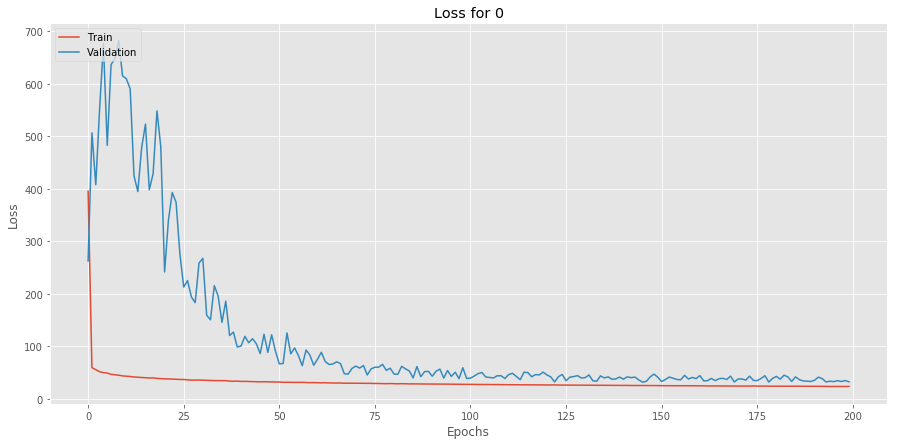

1JHC model saved
Training 1JHN out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 30648 samples, validate on 7663 samples
Epoch 1/200
30648/30648 [==============================] - 1s 36us/sample - loss: 687.9972 - mean_squared_error: 687.9971 - val_loss: 1594.2399 - val_mean_squared_error: 1594.2400
Epoch 2/200
30648/30648 [==============================] - 0s 15us/sample - loss: 111.7655 - mean_squared_error: 111.7655 - val_loss: 1359.2127 - val_mean_squared_error: 1359.2128
Epoch 3/200
30648/30648 [==============================] - 0s 14us/sample - loss: 92.0627 - mean_squared_error: 92.0627 - val_loss: 865.8798 - val_mean_squared_error: 865.8798
Epoch 4/200
30648/30648 [==============================] - 0s 14us/sample - loss: 84.1036 - mean_squared_error: 84.1036 - val_loss: 691.7113 - val_mean_squared_error: 691.7114
Epoch 5/200
30648/30648 [==============================] - 0s 14us/sample - loss: 79.6253 - mean_squared_error: 79.6253 - val_loss: 592.3791 

<Figure size 432x288 with 0 Axes>

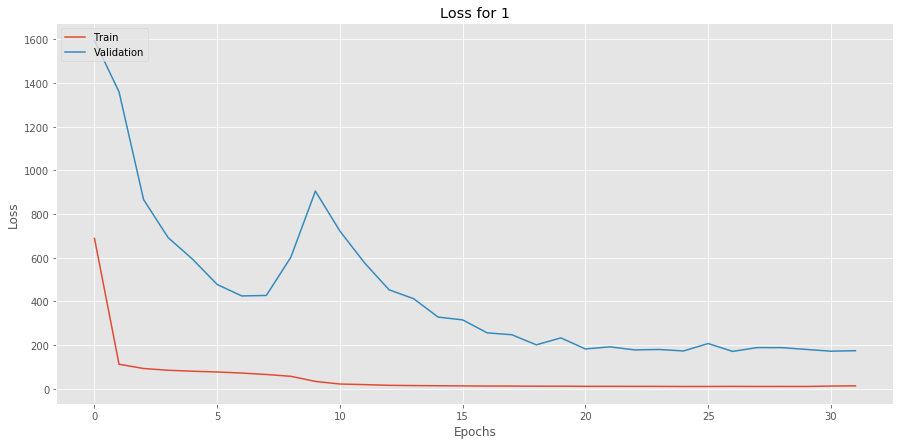

1JHN model saved
Training 2JHC out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 894304 samples, validate on 223577 samples
Epoch 1/200
894304/894304 [==============================] - 14s 16us/sample - loss: 15.4601 - mean_squared_error: 15.4601 - val_loss: 17.0637 - val_mean_squared_error: 17.0637
Epoch 2/200
894304/894304 [==============================] - 13s 15us/sample - loss: 13.3759 - mean_squared_error: 13.3759 - val_loss: 20.9751 - val_mean_squared_error: 20.9751
Epoch 3/200
894304/894304 [==============================] - 13s 15us/sample - loss: 12.7731 - mean_squared_error: 12.7731 - val_loss: 17.6053 - val_mean_squared_error: 17.6053
Epoch 4/200
894304/894304 [==============================] - 13s 15us/sample - loss: 12.4015 - mean_squared_error: 12.4015 - val_loss: 15.8813 - val_mean_squared_error: 15.8813
Epoch 5/200
894304/894304 [==============================] - 13s 15us/sample - loss: 12.1054 - mean_squared_error: 12.1054 - val_loss: 16.3846

<Figure size 432x288 with 0 Axes>

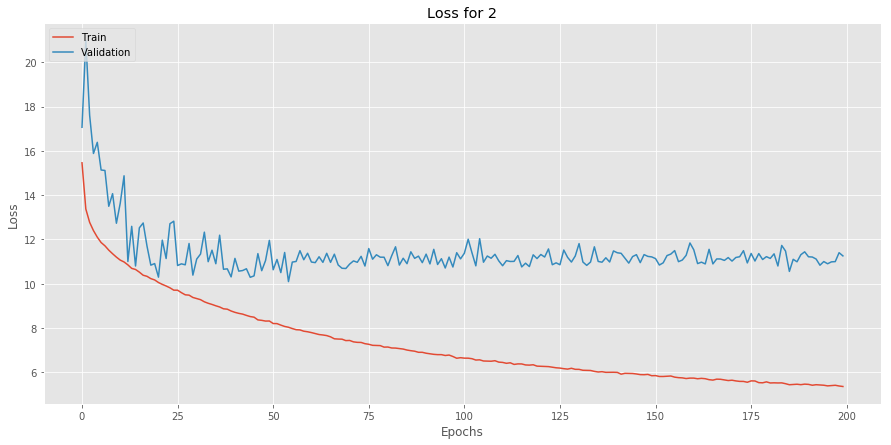

2JHC model saved
Training 2JHH out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 294081 samples, validate on 73521 samples
Epoch 1/200
294081/294081 [==============================] - 5s 17us/sample - loss: 10.9955 - mean_squared_error: 10.9955 - val_loss: nan - val_mean_squared_error: nan
Epoch 2/200
294081/294081 [==============================] - 4s 15us/sample - loss: 4.5373 - mean_squared_error: 4.5373 - val_loss: nan - val_mean_squared_error: nan
Epoch 3/200
294081/294081 [==============================] - 4s 15us/sample - loss: 3.9876 - mean_squared_error: 3.9876 - val_loss: nan - val_mean_squared_error: nan
Epoch 4/200
294081/294081 [==============================] - 4s 15us/sample - loss: 3.7291 - mean_squared_error: 3.7291 - val_loss: nan - val_mean_squared_error: nan
Epoch 5/200
294081/294081 [==============================] - 4s 15us/sample - loss: 3.4926 - mean_squared_error: 3.4926 - val_loss: nan - val_mean_squared_error: nan
Epoch 6/200
294081/

<Figure size 432x288 with 0 Axes>

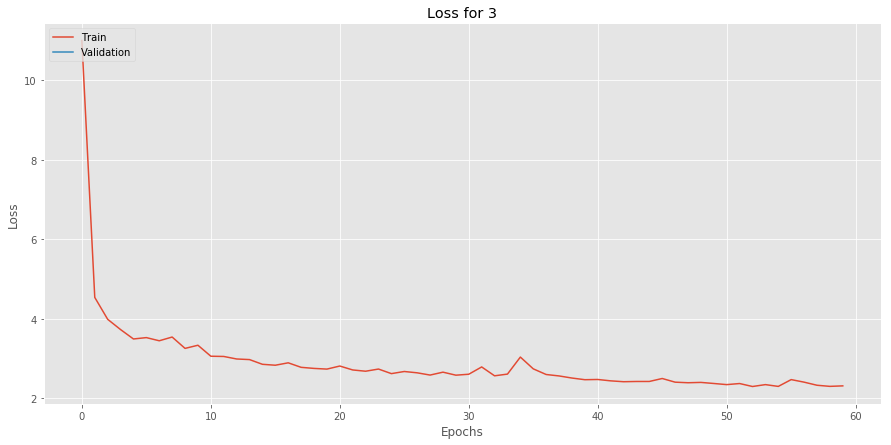

2JHH model saved
Training 2JHN out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 87843 samples, validate on 21961 samples
Epoch 1/200
87843/87843 [==============================] - 2s 22us/sample - loss: 11.6380 - mean_squared_error: 11.6380 - val_loss: 15.6689 - val_mean_squared_error: 15.6689
Epoch 2/200
87843/87843 [==============================] - 1s 14us/sample - loss: 8.5517 - mean_squared_error: 8.5517 - val_loss: 13.8827 - val_mean_squared_error: 13.8827
Epoch 3/200
87843/87843 [==============================] - 1s 14us/sample - loss: 8.0103 - mean_squared_error: 8.0103 - val_loss: 14.4252 - val_mean_squared_error: 14.4252
Epoch 4/200
87843/87843 [==============================] - 1s 14us/sample - loss: 7.4572 - mean_squared_error: 7.4572 - val_loss: 13.4492 - val_mean_squared_error: 13.4492
Epoch 5/200
87843/87843 [==============================] - 1s 14us/sample - loss: 6.9900 - mean_squared_error: 6.9900 - val_loss: 14.7988 - val_mean_squared_error

<Figure size 432x288 with 0 Axes>

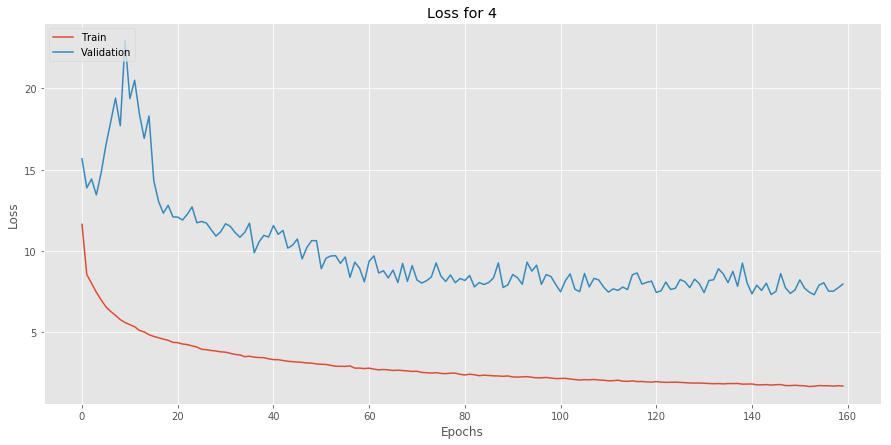

2JHN model saved
Training 3JHC out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 1185481 samples, validate on 296371 samples
Epoch 1/200
1185481/1185481 [==============================] - 19s 16us/sample - loss: 6.6367 - mean_squared_error: 6.6367 - val_loss: 6.4844 - val_mean_squared_error: 6.4844
Epoch 2/200
1185481/1185481 [==============================] - 18s 15us/sample - loss: 5.7331 - mean_squared_error: 5.7331 - val_loss: 6.0388 - val_mean_squared_error: 6.0388
Epoch 3/200
1185481/1185481 [==============================] - 18s 15us/sample - loss: 5.4776 - mean_squared_error: 5.4776 - val_loss: 5.7554 - val_mean_squared_error: 5.7554
Epoch 4/200
1185481/1185481 [==============================] - 18s 15us/sample - loss: 5.3213 - mean_squared_error: 5.3213 - val_loss: 5.3887 - val_mean_squared_error: 5.3887
Epoch 5/200
1185481/1185481 [==============================] - 18s 15us/sample - loss: 5.1971 - mean_squared_error: 5.1970 - val_loss: 5.5022 - val_m

<Figure size 432x288 with 0 Axes>

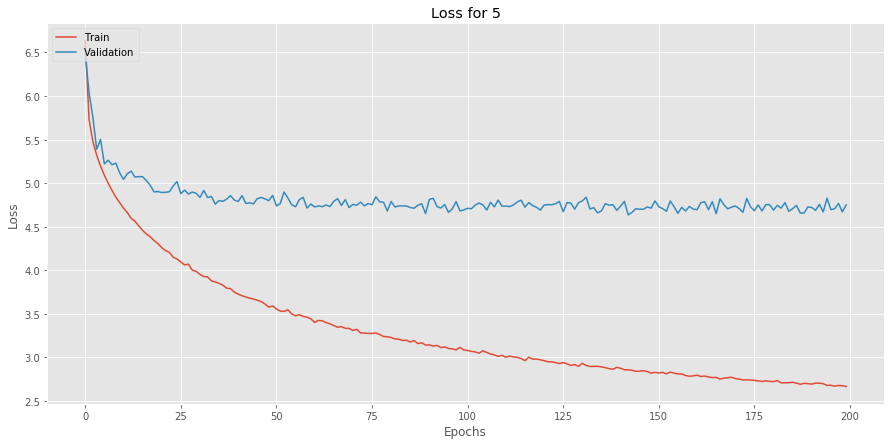

3JHC model saved
Training 3JHH out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 465568 samples, validate on 116392 samples
Epoch 1/200
465568/465568 [==============================] - 8s 16us/sample - loss: 8.1547 - mean_squared_error: 8.1547 - val_loss: 16.2519 - val_mean_squared_error: 16.2519
Epoch 2/200
465568/465568 [==============================] - 7s 15us/sample - loss: 5.8688 - mean_squared_error: 5.8688 - val_loss: 87.1819 - val_mean_squared_error: 87.1819
Epoch 3/200
465568/465568 [==============================] - 7s 15us/sample - loss: 4.9207 - mean_squared_error: 4.9207 - val_loss: 39.2346 - val_mean_squared_error: 39.2346
Epoch 4/200
465568/465568 [==============================] - 7s 15us/sample - loss: 4.5703 - mean_squared_error: 4.5703 - val_loss: 34.5237 - val_mean_squared_error: 34.5237
Epoch 5/200
465568/465568 [==============================] - 7s 15us/sample - loss: 4.3006 - mean_squared_error: 4.3006 - val_loss: 31.5413 - val_mean_squ

<Figure size 432x288 with 0 Axes>

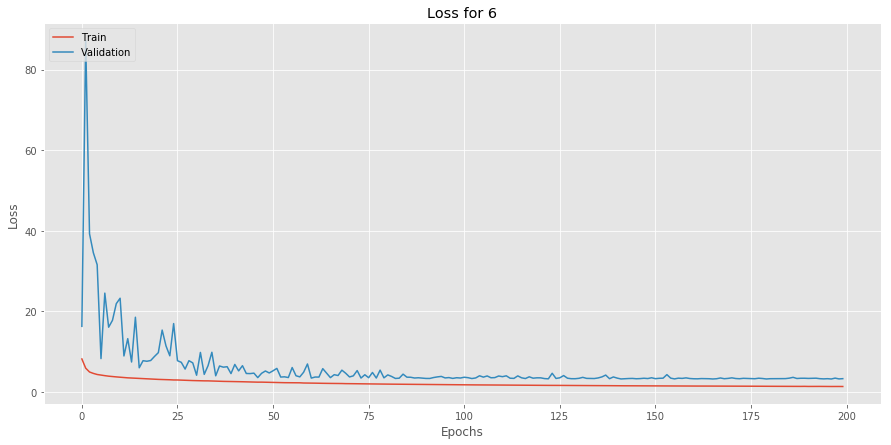

3JHH model saved
Training 3JHN out of ['1JHC' '1JHN' '2JHC' '2JHH' '2JHN' '3JHC' '3JHH' '3JHN'] 

Train on 120809 samples, validate on 30203 samples
Epoch 1/200
120809/120809 [==============================] - 2s 21us/sample - loss: 2.7080 - mean_squared_error: 2.7080 - val_loss: 2.4187 - val_mean_squared_error: 2.4187
Epoch 2/200
120809/120809 [==============================] - 2s 14us/sample - loss: 1.3895 - mean_squared_error: 1.3895 - val_loss: 2.0972 - val_mean_squared_error: 2.0972
Epoch 3/200
120809/120809 [==============================] - 2s 14us/sample - loss: 1.2858 - mean_squared_error: 1.2858 - val_loss: 1.6159 - val_mean_squared_error: 1.6159
Epoch 4/200
120809/120809 [==============================] - 2s 14us/sample - loss: 1.2225 - mean_squared_error: 1.2225 - val_loss: 1.5359 - val_mean_squared_error: 1.5359
Epoch 5/200
120809/120809 [==============================] - 2s 14us/sample - loss: 1.1763 - mean_squared_error: 1.1763 - val_loss: 1.5201 - val_mean_squared_error

<Figure size 432x288 with 0 Axes>

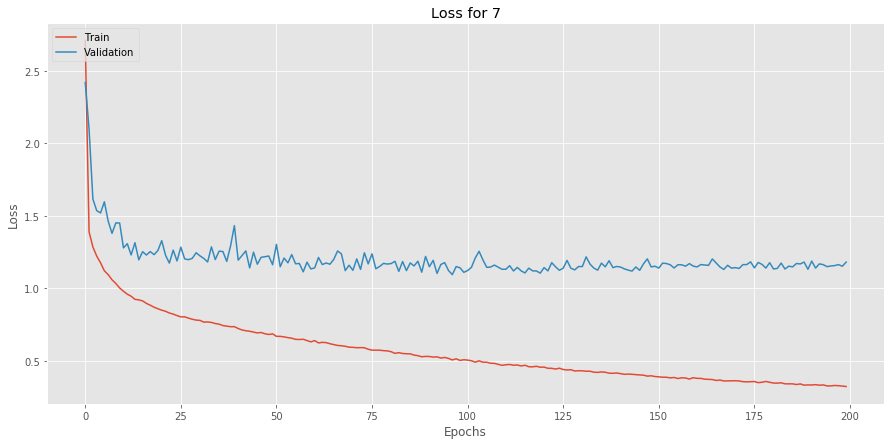

3JHN model saved


In [33]:

# creating a numpy array of zeroes having the length of test dataframe
test_prediction=np.zeros(len(test))


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.7

#running the tensorflow session with above config
sess = tf.Session(config=config) 
K.set_session(sess)

types = np.sort(train['type'].unique())

type_list = lbl.inverse_transform(types)
for t in types:
    
    
    print('Training %s' %type_list[t], 'out of', type_list, '\n')
    x_train=train[train["type"]==t]
    y_train=x_train.loc[:,"scalar_coupling_constant"].values
    x_train=x_train.drop(['scalar_coupling_constant'],axis=1)
    x_test=test[test["type"]==t]
    
    
    
    model = create_model() 
    
    # setting up callbacks to stop traning if loss is not going down for specified number of epochs
    early_stopping = callbacks.EarlyStopping(monitor='loss',patience=7,mode='auto', restore_best_weights=True)
    
    # fitting the model
    history = model.fit(x_train,y_train,epochs=200,batch_size=2000,validation_split=0.2,callbacks=[early_stopping])
    
    plot_history(history, t)
    
    
    model.save("./type_{}_model.h5".format(type_list[t]))
    print("{} model saved".format(type_list[t]))
    
    losses[t] = pd.Series(history.history['loss'])
    val_losses[t]= pd.Series(history.history['val_loss'])
    

    #getting predictions for the test set
    test_predict=model.predict(x_test)
    test_predict = test_predict.reshape(-1)
    
    test_prediction[test["type"]==t]=test_predict
    
    K.clear_session()
    
    


In [17]:
#Decoding the molecule types which were encoded using the labelencoder

#columns = lbl.inverse_transform(losses.columns)
#losses.columns= columns
#val_losses.columns = columns

In [3]:
columns = ['1JHC', '2JHH', '1JHN', '2JHC', '2JHN', '3JHC', '3JHH','3JHN']

In [5]:
#plotting graph of stored validation loss for each molecule type

def traces(a,name):
    trace= go.Scatter(
        x=val_losses.index.values,
        y=a,
        name = name
    )
    return trace

t1= traces(val_losses.iloc[:150,1],columns[0])
t2= traces(val_losses.iloc[:150,2],columns[1])
t3= traces(val_losses.iloc[:150,3],columns[2])
t4= traces(val_losses.iloc[:150,4],columns[3])
t5= traces(val_losses.iloc[:150,5],columns[4])
t6= traces(val_losses.iloc[:150,6],columns[5])
t7= traces(val_losses.iloc[:150,7],columns[6])
t8= traces(val_losses.iloc[:150,8],columns[7])


data= [t1,t2,t3,t4,t5,t6,t7,t8]

layout = go.Layout(
    title='Validation loss over the epochs',
    xaxis=dict(
        title='Epochs',
        titlefont=dict(
            family='Courier New, monospace',
            size=15,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Validation loss',
        titlefont=dict(
            family='Courier New, monospace',
            size=15,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)



In [45]:
#writing out the submission to the submissions file
sample_sub = pd.read_csv('./sample_submission.csv')
sample_sub['scalar_coupling_constant']= test_prediction
print(sample_sub.head())

        id  scalar_coupling_constant
0  4658147                  0.745387
1  4658148                147.478668
2  4658149                 -0.032760
3  4658150                161.704086
4  4658151                 19.139683


In [0]:
sample_sub.to_csv('submission.csv',index=False)